In [1]:
from IPython.display import Image
from os import chdir
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# read the file
file_name = "function_rips_with_threshold_10000_1"

x_min = 1000000
x_max = -1000000
y_min = 1000000
y_max = -1000000

rank_dim = 0

simplices = []
vertice_id = 1
i = 0

for line in open("../cgta_paper_2021/function_rips/"+file_name+".scc"):
#for line in open("./data/"+file_name+".scc"):
    if(line[0]!='#'):
        
        if(i<=1):
            i=i+1
            continue
            
        elif(i==2):
            rank_num=[] # sizes of generating sets
            for j in line.split():
                rank_num.append(int(j))
            i=i+1
            rank_num=rank_num[:-1]
            print("rank_num=",rank_num)
        else:
            block = line.split(';')
            grid = block[0].split()
            #grid_x = int(grid[0])
            #grid_y = int(grid[1])
            grid_x = int(float(grid[0])*20)
            grid_y = int(float(grid[1])*20)
            
            if grid_x > x_max:
                x_max = grid_x
            if grid_y > y_max:
                y_max = grid_y
            if grid_x < x_min:
                x_min = grid_x
            if grid_y < y_min:
                y_min = grid_y
            
            if len(block)>1:
                face = block[1].split()
                for j in range(len(face)):
                    face[j] = int(face[j])
                simplices.append([grid_x,grid_y,face])
                
            else:
                simplices.append([grid_x,grid_y,[vertice_id]])
                vertice_id += 1
            i=i+1   

#end_point = [x_range,y_range] 


simplex_tree = []
start_id=0
for i in range(len(rank_num)-1,-1,-1):
    simplices_i=[]
    for j in range(len(simplices)-start_id-rank_num[i],len(simplices)-start_id):
        simplices_i.append(simplices[j])
    start_id += rank_num[i]
    simplex_tree.append(simplices_i)


for i in range(1,len(simplex_tree)):
    for j in range(len(simplex_tree[i])):
        simplex = simplex_tree[i][j]
        face = simplex[2]
        vertices=[]
        for face_id in face:
            vert = simplex_tree[i-1][face_id][2]
            for vert_id in vert:
                if vert_id not in vertices:
                    vertices.append(vert_id)
        simplex_tree[i][j][2]=vertices



## To verify the data structur
## simplices contain all the information we need
#print("the simplex tree:")
#for i in range(len(simplex_tree)):
#    for simplex in simplex_tree[i]:
#        print(simplex)   

       


rank_num= [4136, 3458, 1913, 500]


In [3]:
print("x_min",x_min)
print("x_max",x_max)
print("y_min",y_min)
print("y_max",y_max)

x_range = x_max - x_min
y_range = y_max - y_min
print("x_range=",x_range)
print("y_range=",y_range)

end_point = [x_range,y_range]

x_min 0
x_max 5
y_min -31
y_max -4
x_range= 5
y_range= 27


## Compute rank invariant

In [4]:
def create_stair(elbow, end_point):
    # stair a path passing through the elbow.
    stair = []
    
    if(elbow[0]==0 or elbow[1]==end_point[1]):
        for i in range(end_point[1]+1):
            stair.append([0,i])
        for j in range(1,end_point[0]+1):
            stair.append([j,i])
    else:
        for i in range(elbow[1]+1):
            stair.append([0,i])   # i=0
        for j in range(elbow[0]):
            stair.append([j+1,i]) # j=0
        for k in range(i+1, end_point[1]+1):
            stair.append([j+1,k]) # k=2,3
        for l in range(j+2, end_point[0]+1):
            stair.append([l,k])
    return stair

def compute_rk(i,j,k,l,barcodes,rank_dim):
# This function computes the value rank(s,t) where s=(i,j) and t = (k,l)
    if(i>k or j>l):
        return 0
    
    s_1 = i + j
    t_1 = k + l
    rank0_inv = 0
    rank1_inv = 0

    for barcode in barcodes:
        if(barcode[0]==0):
            if(barcode[1][0]<=s_1 and barcode[1][1]>t_1):
                rank0_inv = rank0_inv + 1
        elif(barcode[0]==1):
            if(barcode[1][0]<=s_1 and barcode[1][1]>t_1):
                rank1_inv = rank1_inv + 1
    if(rank_dim==0):
        return rank0_inv
    elif(rank_dim==1):
        return rank1_inv
    

In [5]:
import time
#grid is from (0,0)
#vertex index is from 1
rank_inv = np.array(np.zeros((x_range+1,y_range+1,x_range+1,y_range+1)))

st = gd.SimplexTree()
#result_rank_fn="./result/rank1_invariance_for_"+file_name+".txt"
#f_rank = f.open(result_rank_fn,"w")



#Scan all the elbows
for i in range(x_range+1):
    for j in range(y_range+1):
        elbow = [i,j]
        #print("elbow",elbow)
        #print("time: start building a simplex tree",time.asctime( time.localtime(time.time()) ))
        stair = create_stair(elbow, end_point)
        #print("stair",stair)

        # Build the simplex tree
        
        for ii in range(len(simplex_tree)):
            for jj in range(len(simplex_tree[ii])):
                simplex = simplex_tree[ii][jj]
                for grid_id in stair:
                    if (simplex[0]-x_min)<=grid_id[0] and (simplex[1]-y_min)<=grid_id[1]:
                        filtration_value = grid_id[0]+grid_id[1] #TODO
                        #print("time enter insert/assign ", time.asctime( time.localtime(time.time())))
                        if((st.insert(simplex[2], filtration = filtration_value))==False): #TODO:optimize with C++, we don't have the funciton for Python
                            #print("time finish insert",time.asctime( time.localtime(time.time())))
                            st.assign_filtration(simplex[2], filtration = filtration_value)
                        break
                        
        #print("time: finish building a simplex tree",time.asctime( time.localtime(time.time()) ))
        
        st_gen = st.get_filtration() 
        #for splx in st_gen :
        #    print(splx)
        
        barcodes = st.persistence()
        #print("barcodes,",barcodes)
        
        #print("time finish building a simplex tree for one elbow",time.asctime( time.localtime(time.time()) ))
        
        for start_id in range(len(stair)):
            for end_id in range(start_id,len(stair)):
                grid_start = stair[start_id]
                grid_end = stair[end_id]
                [ri,rj,rk,rl]=[grid_start[0],grid_start[1],grid_end[0],grid_end[1]]
                #print("[ri,rj,rk,rl]=",[ri,rj,rk,rl])
                rank_inv[ri,rj,rk,rl]=compute_rk(ri,rj,rk,rl,barcodes,rank_dim)
                
        #print("time finish calculating rank invariance",time.asctime(time.localtime(time.time())))

        
                

In [6]:
#Now it's rank0_invariance
np.save("./result/rank"+str(rank_dim)+"_invariance_for_"+file_name,rank_inv)
for i in range(x_range+1):
    for j in range(y_range+1):
        for k in range(i,x_range+1):
            for l in range(j,y_range+1):
                print("rank(({0},{1}),({2},{3}))={4}".format(i,j,k,l,int(rank_inv[i,j,k,l])))


rank((0,0),(0,0))=1
rank((0,0),(0,1))=1
rank((0,0),(0,2))=1
rank((0,0),(0,3))=1
rank((0,0),(0,4))=1
rank((0,0),(0,5))=1
rank((0,0),(0,6))=1
rank((0,0),(0,7))=1
rank((0,0),(0,8))=1
rank((0,0),(0,9))=1
rank((0,0),(0,10))=1
rank((0,0),(0,11))=1
rank((0,0),(0,12))=1
rank((0,0),(0,13))=1
rank((0,0),(0,14))=1
rank((0,0),(0,15))=1
rank((0,0),(0,16))=1
rank((0,0),(0,17))=1
rank((0,0),(0,18))=1
rank((0,0),(0,19))=1
rank((0,0),(0,20))=1
rank((0,0),(0,21))=1
rank((0,0),(0,22))=1
rank((0,0),(0,23))=1
rank((0,0),(0,24))=1
rank((0,0),(0,25))=1
rank((0,0),(0,26))=1
rank((0,0),(0,27))=1
rank((0,0),(1,0))=1
rank((0,0),(1,1))=1
rank((0,0),(1,2))=1
rank((0,0),(1,3))=1
rank((0,0),(1,4))=1
rank((0,0),(1,5))=1
rank((0,0),(1,6))=1
rank((0,0),(1,7))=1
rank((0,0),(1,8))=1
rank((0,0),(1,9))=1
rank((0,0),(1,10))=1
rank((0,0),(1,11))=1
rank((0,0),(1,12))=1
rank((0,0),(1,13))=1
rank((0,0),(1,14))=1
rank((0,0),(1,15))=1
rank((0,0),(1,16))=1
rank((0,0),(1,17))=1
rank((0,0),(1,18))=1
rank((0,0),(1,19))=1
rank((0,0),(

rank((0,15),(3,26))=6
rank((0,15),(3,27))=6
rank((0,15),(4,15))=14
rank((0,15),(4,16))=14
rank((0,15),(4,17))=13
rank((0,15),(4,18))=13
rank((0,15),(4,19))=13
rank((0,15),(4,20))=12
rank((0,15),(4,21))=10
rank((0,15),(4,22))=5
rank((0,15),(4,23))=1
rank((0,15),(4,24))=1
rank((0,15),(4,25))=1
rank((0,15),(4,26))=1
rank((0,15),(4,27))=1
rank((0,15),(5,15))=14
rank((0,15),(5,16))=14
rank((0,15),(5,17))=13
rank((0,15),(5,18))=12
rank((0,15),(5,19))=12
rank((0,15),(5,20))=9
rank((0,15),(5,21))=6
rank((0,15),(5,22))=2
rank((0,15),(5,23))=1
rank((0,15),(5,24))=1
rank((0,15),(5,25))=1
rank((0,15),(5,26))=1
rank((0,15),(5,27))=1
rank((0,16),(0,16))=69
rank((0,16),(0,17))=69
rank((0,16),(0,18))=69
rank((0,16),(0,19))=69
rank((0,16),(0,20))=69
rank((0,16),(0,21))=69
rank((0,16),(0,22))=69
rank((0,16),(0,23))=69
rank((0,16),(0,24))=69
rank((0,16),(0,25))=69
rank((0,16),(0,26))=69
rank((0,16),(0,27))=69
rank((0,16),(1,16))=29
rank((0,16),(1,17))=29
rank((0,16),(1,18))=29
rank((0,16),(1,19))=29
rank

rank((1,8),(2,11))=3
rank((1,8),(2,12))=3
rank((1,8),(2,13))=3
rank((1,8),(2,14))=3
rank((1,8),(2,15))=3
rank((1,8),(2,16))=3
rank((1,8),(2,17))=3
rank((1,8),(2,18))=3
rank((1,8),(2,19))=3
rank((1,8),(2,20))=3
rank((1,8),(2,21))=3
rank((1,8),(2,22))=3
rank((1,8),(2,23))=3
rank((1,8),(2,24))=3
rank((1,8),(2,25))=3
rank((1,8),(2,26))=3
rank((1,8),(2,27))=3
rank((1,8),(3,8))=3
rank((1,8),(3,9))=3
rank((1,8),(3,10))=3
rank((1,8),(3,11))=3
rank((1,8),(3,12))=3
rank((1,8),(3,13))=3
rank((1,8),(3,14))=3
rank((1,8),(3,15))=3
rank((1,8),(3,16))=3
rank((1,8),(3,17))=3
rank((1,8),(3,18))=3
rank((1,8),(3,19))=3
rank((1,8),(3,20))=3
rank((1,8),(3,21))=3
rank((1,8),(3,22))=2
rank((1,8),(3,23))=2
rank((1,8),(3,24))=2
rank((1,8),(3,25))=2
rank((1,8),(3,26))=2
rank((1,8),(3,27))=2
rank((1,8),(4,8))=3
rank((1,8),(4,9))=3
rank((1,8),(4,10))=3
rank((1,8),(4,11))=3
rank((1,8),(4,12))=3
rank((1,8),(4,13))=3
rank((1,8),(4,14))=3
rank((1,8),(4,15))=3
rank((1,8),(4,16))=3
rank((1,8),(4,17))=3
rank((1,8),(4,18)

rank((2,4),(4,5))=1
rank((2,4),(4,6))=1
rank((2,4),(4,7))=1
rank((2,4),(4,8))=1
rank((2,4),(4,9))=1
rank((2,4),(4,10))=1
rank((2,4),(4,11))=1
rank((2,4),(4,12))=1
rank((2,4),(4,13))=1
rank((2,4),(4,14))=1
rank((2,4),(4,15))=1
rank((2,4),(4,16))=1
rank((2,4),(4,17))=1
rank((2,4),(4,18))=1
rank((2,4),(4,19))=1
rank((2,4),(4,20))=1
rank((2,4),(4,21))=1
rank((2,4),(4,22))=1
rank((2,4),(4,23))=1
rank((2,4),(4,24))=1
rank((2,4),(4,25))=1
rank((2,4),(4,26))=1
rank((2,4),(4,27))=1
rank((2,4),(5,4))=1
rank((2,4),(5,5))=1
rank((2,4),(5,6))=1
rank((2,4),(5,7))=1
rank((2,4),(5,8))=1
rank((2,4),(5,9))=1
rank((2,4),(5,10))=1
rank((2,4),(5,11))=1
rank((2,4),(5,12))=1
rank((2,4),(5,13))=1
rank((2,4),(5,14))=1
rank((2,4),(5,15))=1
rank((2,4),(5,16))=1
rank((2,4),(5,17))=1
rank((2,4),(5,18))=1
rank((2,4),(5,19))=1
rank((2,4),(5,20))=1
rank((2,4),(5,21))=1
rank((2,4),(5,22))=1
rank((2,4),(5,23))=1
rank((2,4),(5,24))=1
rank((2,4),(5,25))=1
rank((2,4),(5,26))=1
rank((2,4),(5,27))=1
rank((2,5),(2,5))=2
rank

rank((3,4),(4,10))=1
rank((3,4),(4,11))=1
rank((3,4),(4,12))=1
rank((3,4),(4,13))=1
rank((3,4),(4,14))=1
rank((3,4),(4,15))=1
rank((3,4),(4,16))=1
rank((3,4),(4,17))=1
rank((3,4),(4,18))=1
rank((3,4),(4,19))=1
rank((3,4),(4,20))=1
rank((3,4),(4,21))=1
rank((3,4),(4,22))=1
rank((3,4),(4,23))=1
rank((3,4),(4,24))=1
rank((3,4),(4,25))=1
rank((3,4),(4,26))=1
rank((3,4),(4,27))=1
rank((3,4),(5,4))=1
rank((3,4),(5,5))=1
rank((3,4),(5,6))=1
rank((3,4),(5,7))=1
rank((3,4),(5,8))=1
rank((3,4),(5,9))=1
rank((3,4),(5,10))=1
rank((3,4),(5,11))=1
rank((3,4),(5,12))=1
rank((3,4),(5,13))=1
rank((3,4),(5,14))=1
rank((3,4),(5,15))=1
rank((3,4),(5,16))=1
rank((3,4),(5,17))=1
rank((3,4),(5,18))=1
rank((3,4),(5,19))=1
rank((3,4),(5,20))=1
rank((3,4),(5,21))=1
rank((3,4),(5,22))=1
rank((3,4),(5,23))=1
rank((3,4),(5,24))=1
rank((3,4),(5,25))=1
rank((3,4),(5,26))=1
rank((3,4),(5,27))=1
rank((3,5),(3,5))=2
rank((3,5),(3,6))=2
rank((3,5),(3,7))=2
rank((3,5),(3,8))=2
rank((3,5),(3,9))=2
rank((3,5),(3,10))=2
ran

rank((5,15),(5,18))=12
rank((5,15),(5,19))=12
rank((5,15),(5,20))=9
rank((5,15),(5,21))=6
rank((5,15),(5,22))=2
rank((5,15),(5,23))=1
rank((5,15),(5,24))=1
rank((5,15),(5,25))=1
rank((5,15),(5,26))=1
rank((5,15),(5,27))=1
rank((5,16),(5,16))=16
rank((5,16),(5,17))=15
rank((5,16),(5,18))=14
rank((5,16),(5,19))=14
rank((5,16),(5,20))=11
rank((5,16),(5,21))=7
rank((5,16),(5,22))=2
rank((5,16),(5,23))=1
rank((5,16),(5,24))=1
rank((5,16),(5,25))=1
rank((5,16),(5,26))=1
rank((5,16),(5,27))=1
rank((5,17),(5,17))=19
rank((5,17),(5,18))=18
rank((5,17),(5,19))=18
rank((5,17),(5,20))=12
rank((5,17),(5,21))=7
rank((5,17),(5,22))=2
rank((5,17),(5,23))=1
rank((5,17),(5,24))=1
rank((5,17),(5,25))=1
rank((5,17),(5,26))=1
rank((5,17),(5,27))=1
rank((5,18),(5,18))=24
rank((5,18),(5,19))=20
rank((5,18),(5,20))=14
rank((5,18),(5,21))=8
rank((5,18),(5,22))=2
rank((5,18),(5,23))=1
rank((5,18),(5,24))=1
rank((5,18),(5,25))=1
rank((5,18),(5,26))=1
rank((5,18),(5,27))=1
rank((5,19),(5,19))=24
rank((5,19),(5,20

## compute multiplicity

In [18]:
#
#m((i,j),(k,l))
def multp(rank, i,j,k,l):
    if(i<0 or j<0 or k>rank.shape[1] or l>rank.shape[0]):   
        return 0
    
    res = rank[i,j,k,l]
    print("res=",res)
    if(k+1<rank.shape[0]):
        print("rank[i,j,k+1,l]=",rank[i,j,k+1,l])
        res -= rank[i,j,k+1,l]
        print("res=",res)
    if(l+1<rank.shape[1]):
        print("rank[i,j,k,l+1]=",rank[i,j,k,l+1])
        res -= rank[i,j,k,l+1]
        print("res=",res)
    if(k+1<rank.shape[0] and l+1<rank.shape[1]):
        print("rank[i,j,k+1,l+1]=",rank[i,j,k+1,l+1])
        res += rank[i,j,k+1,l+1]
        print("res=",res)
    print("=================multp(({0},{1}),({2},{3}))={4}===================".format(i,j,k,l,res))
    return res
    

def compute_R_S_incl_excl(rank):
    multiplicity = np.zeros_like(rank)
    for i in range(rank.shape[0]):
        for j in range(rank.shape[1]):
            for k in range(i,rank.shape[0]):
                for l in range(j,rank.shape[1]):
                    m = multp(rank,i,j,k,l)-multp(rank,i-1,j,k,l)-multp(rank,i,j-1,k,l)+multp(rank,i-1,j-1,k,l)
                    if(m!=0):
                        multiplicity[i,j,k,l] = m
    return multiplicity
    

In [21]:
rank_inv.shape

(6, 28, 6, 28)

In [19]:

m = compute_R_S_incl_excl(rank_inv)

np.save("./result/rank"+str(rank_dim)+"_multiplicity_for_"+file_name,m)

res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(0,0))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(0,1))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(0,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(0,3))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(0,4))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(0,5))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res=

rank[i,j,k+1,l]= 1.0
res= 1.0
rank[i,j,k,l+1]= 2.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,1),(0,3))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 1.0
res= 1.0
rank[i,j,k,l+1]= 2.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,2),(0,4))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 1.0
res= 1.0
rank[i,j,k,l+1]= 2.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,1),(0,4))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 1.0
res= 1.0
rank[i,j,k,l+1]= 2.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,2),(0,5))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 1.0
res= 1.0
rank[i,j,k,l+1]= 2.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,1),(0,5))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 1.0
res= 1.0
rank[i,j,k,l+1]= 2.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,2),(0,6))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 1.0
res= 1.0
rank

rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,4),(0,6))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 1.0
res= 1.0
rank[i,j,k,l+1]= 2.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,3),(0,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,4),(1,4))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,3),(1,4))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,4),(1,5))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,3),(1,5))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
==

res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(3,5))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,0),(3,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(3,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,0),(4,0))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(4,0))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,0),(4,1))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res=

rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,1),(4,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,1),(4,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,0),(4,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,0),(4,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,1),(4,3))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,1),(4,3))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
ran

res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,3),(1,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,2),(1,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,2),(1,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,3),(2,3))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,3),(2,3))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,2),(2,3))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res=

res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,4),(1,6))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 2.0
res= 0.0
rank[i,j,k,l+1]= 2.0
res= -2.0
rank[i,j,k+1,l+1]= 2.0
res= 0.0
=================multp((1,5),(2,5))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 2.0
res= 0.0
rank[i,j,k,l+1]= 2.0
res= -2.0
rank[i,j,k+1,l+1]= 2.0
res= 0.0
=================multp((0,5),(2,5))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,4),(2,5))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((0,4),(2,5))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 2.0
res= 0.0
rank[i,j,k,l+1]= 2.0
res= -2.0
rank[i,j,k+1,l+1]= 2.0
res= 0.0
=================multp((1,5),(2,6))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 2.0
res= 0.0
rank[i,j,k,l+1]= 2.0
res= -2.0
rank[i,j,k+1,l+1]= 2.0
r

res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,0),(2,3))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,1),(2,4))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,1),(2,4))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,0),(2,4))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,0),(2,4))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,1),(2,5))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res=

res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,2),(3,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,2),(3,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,1),(3,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,1),(3,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,2),(4,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,2),(4,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res=

res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,4),(2,5))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 2.0
res= 0.0
rank[i,j,k,l+1]= 2.0
res= -2.0
rank[i,j,k+1,l+1]= 2.0
res= 0.0
=================multp((2,5),(2,6))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 2.0
res= 0.0
rank[i,j,k,l+1]= 2.0
res= -2.0
rank[i,j,k+1,l+1]= 2.0
res= 0.0
=================multp((1,5),(2,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,4),(2,6))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((1,4),(2,6))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 2.0
res= 0.0
rank[i,j,k,l+1]= 2.0
res= -2.0
rank[i,j,k+1,l+1]= 2.0
res= 0.0
=================multp((2,5),(3,5))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 2.0
res=

=================multp((3,2),(3,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,2),(3,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((3,1),(3,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,1),(3,2))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((3,2),(3,3))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((2,2),(3,3))=0.0===================
res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((3,1),(3,3)

res= 0.0
=================multp((2,4),(4,6))=0.0===================
res= 2.0
rank[i,j,k,l+1]= 2.0
res= 0.0
=================multp((3,5),(5,5))=0.0===================
res= 2.0
rank[i,j,k,l+1]= 2.0
res= 0.0
=================multp((2,5),(5,5))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((3,4),(5,5))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((2,4),(5,5))=0.0===================
res= 2.0
rank[i,j,k,l+1]= 2.0
res= 0.0
=================multp((3,5),(5,6))=0.0===================
res= 2.0
rank[i,j,k,l+1]= 2.0
res= 0.0
=================multp((2,5),(5,6))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((3,4),(5,6))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((2,4),(5,6))=0.0===================
res= 2.0
rank[i,j,k+1,l]= 2.0
res= 0.0
rank[i,j,k,l+1]= 2.0
res= -2.0
rank[i,j,k+1,l+1]= 2.0
res= 0.0
=================multp((3,6),(3,6))=0.0=======

res= 1.0
rank[i,j,k+1,l]= 1.0
res= 0.0
rank[i,j,k,l+1]= 1.0
res= -1.0
rank[i,j,k+1,l+1]= 1.0
res= 0.0
=================multp((3,3),(4,6))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((4,4),(5,4))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((3,4),(5,4))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((4,3),(5,4))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((3,3),(5,4))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((4,4),(5,5))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((3,4),(5,5))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((4,3),(5,5))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
=================multp((3,3),(5,5))=0.0===================
res= 1.0
rank[i,j,k,l+1]= 1.0
res= 0.0
================

### Draw grid for multiplicity

(6, 28, 6, 28)


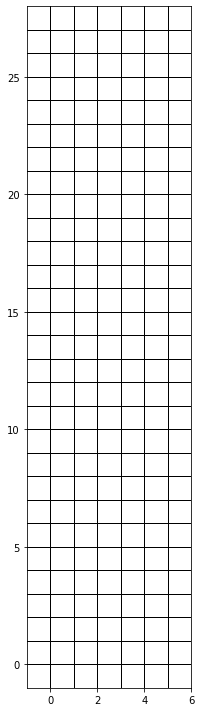

In [9]:
data = np.ones((x_range,y_range)) * np.nan

fig, ax = plt.subplots(1, 1, figsize=(10,10),tight_layout=True)
for x in range(x_range+1):
    ax.axvline(x, lw=1, color='k', zorder=5) # Horizontal 
for y in range(y_range+1):
    ax.axhline(y, lw=1, color='k', zorder=5) # Ordinate
print(m.shape)

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        for k in range(i,m.shape[0]):
            for l in range(j,m.shape[1]):
                if(m[i,j,k,l]):
                    print("m(({0},{1}),({2},{3}))={4}".format(i,j,k,l,int(m[i,j,k,l])))
                if(m[i,j,k,l]>0):
                    if(i==k and j==l):
                        ax.plot([i, k], [j, l],'bo', linestyle="-")
                    elif(i==k):
                        ax.plot([i+0.08, k+0.08], [j, l],'bv', linestyle="-")
                    elif(j==l):
                        ax.plot([i, k], [j+0.08, l+0.08],'bv',linestyle="-")
                    else:  
                        ax.plot([i, k], [j, l],'bv', linestyle="-")
                if(m[i,j,k,l]<0):
                    if(i==k and j==l):
                        ax.plot([i, k], [j, l],'ro', linestyle="-")
                    elif(i==k):
                        ax.plot([i-0.08, k-0.08], [j, l],'rv', linestyle="-")
                    elif(j==l):
                        ax.plot([i, k], [j-0.08, l-0.08],'rv', linestyle="-")
                    else:  
                        ax.plot([i, k], [j, l], 'rv', linestyle="-")

ax.imshow(data, interpolation='none', extent=[-1,x_range+1, -1, y_range+1], zorder=0)

#ax.axis('off')